In [21]:
# Setup feedback system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import importlib
import os

import start_utils
from start_utils import (
    create_features, read_train_data, read_test_data, 
    simple_train, build_pipe, train_regularization, 
    #greedy_feature_selection, random_bucket_feature_search, 
    predict_and_submit)
importlib.reload(start_utils)

# Set Matplotlib defaults
#plt.style.use("seaborn-whitegrid")
#import seaborn as sns
sns.set_theme(style="whitegrid")




# Load data
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')

train_data = read_train_data(train_file_path)
test_data = read_test_data(test_file_path)

#2 create features
# Create feature DataFrames for both training and test sets
print("Processing training data...")
df = create_features(train_data)
#df = pd.read_csv("../input/fe-course-data/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    """
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    """
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.rc("figure", autolayout=True)
    plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=14,
        titlepad=10,
    )
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
df.columns

Index(['p1_major_status_infliction_rate',
       'p1_cumulative_major_status_turns_pct',
       'p2_major_status_infliction_rate',
       'p2_cumulative_major_status_turns_pct', 'p1_max_offense_boost_diff',
       'p1_team_super_effective_moves', 'expected_damage_ratio_turn_1',
       'p1_max_offensive_stat', 'p1_max_speed_stat', 'p1_mean_hp',
       'p1_mean_spe', 'p1_mean_atk', 'p1_mean_def', 'p1_mean_sp', 'diff_hp',
       'diff_spe', 'diff_atk', 'diff_def', 'diff_spd', 'priority_diff',
       'priority_rate_advantage', 'mean_base_atk_diff_timeline',
       'std_base_atk_diff_timeline', 'mean_base_spa_diff_timeline',
       'std_base_spa_diff_timeline', 'mean_base_spe_diff_timeline',
       'std_base_spe_diff_timeline', 'hp_diff_mean', 'p1_hp_advantage_mean',
       'p1_n_pokemon_use', 'p2_n_pokemon_use', 'diff_final_schieramento',
       'nr_pokemon_sconfitti_p1', 'nr_pokemon_sconfitti_p2',
       'nr_pokemon_sconfitti_diff', 'p1_pct_final_hp', 'p2_pct_final_hp',
       'diff_final

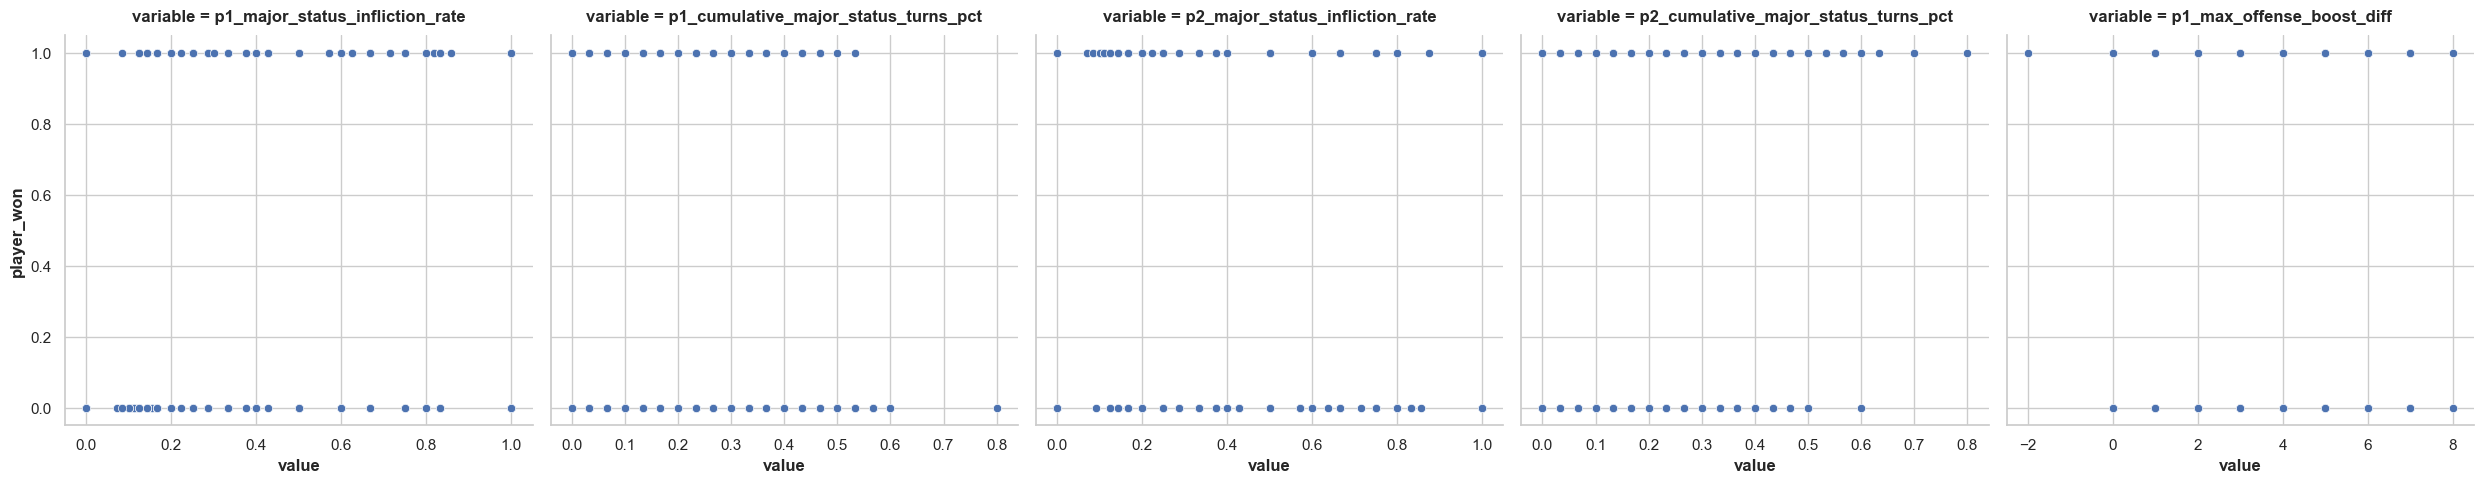

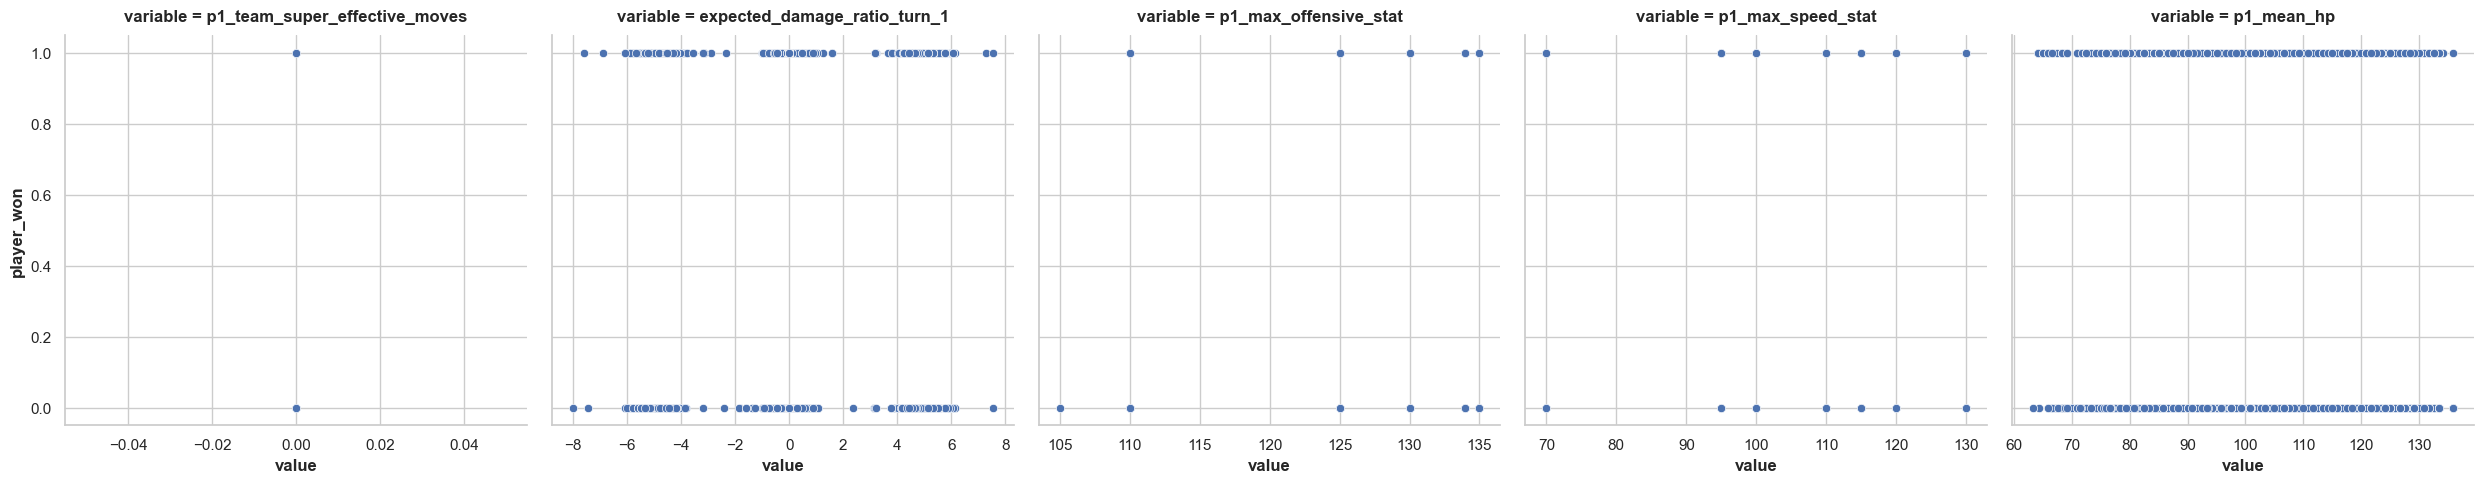

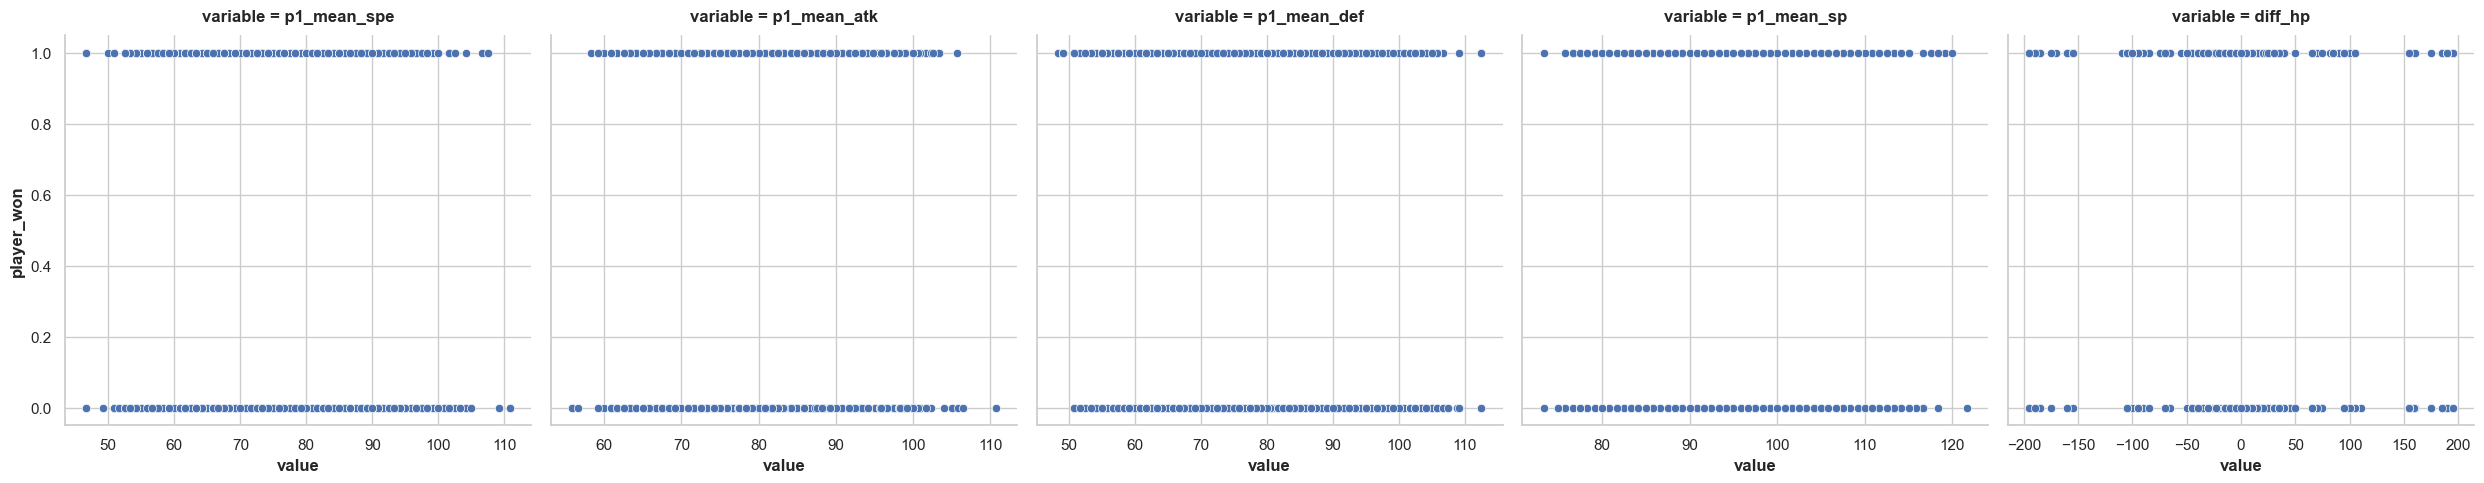

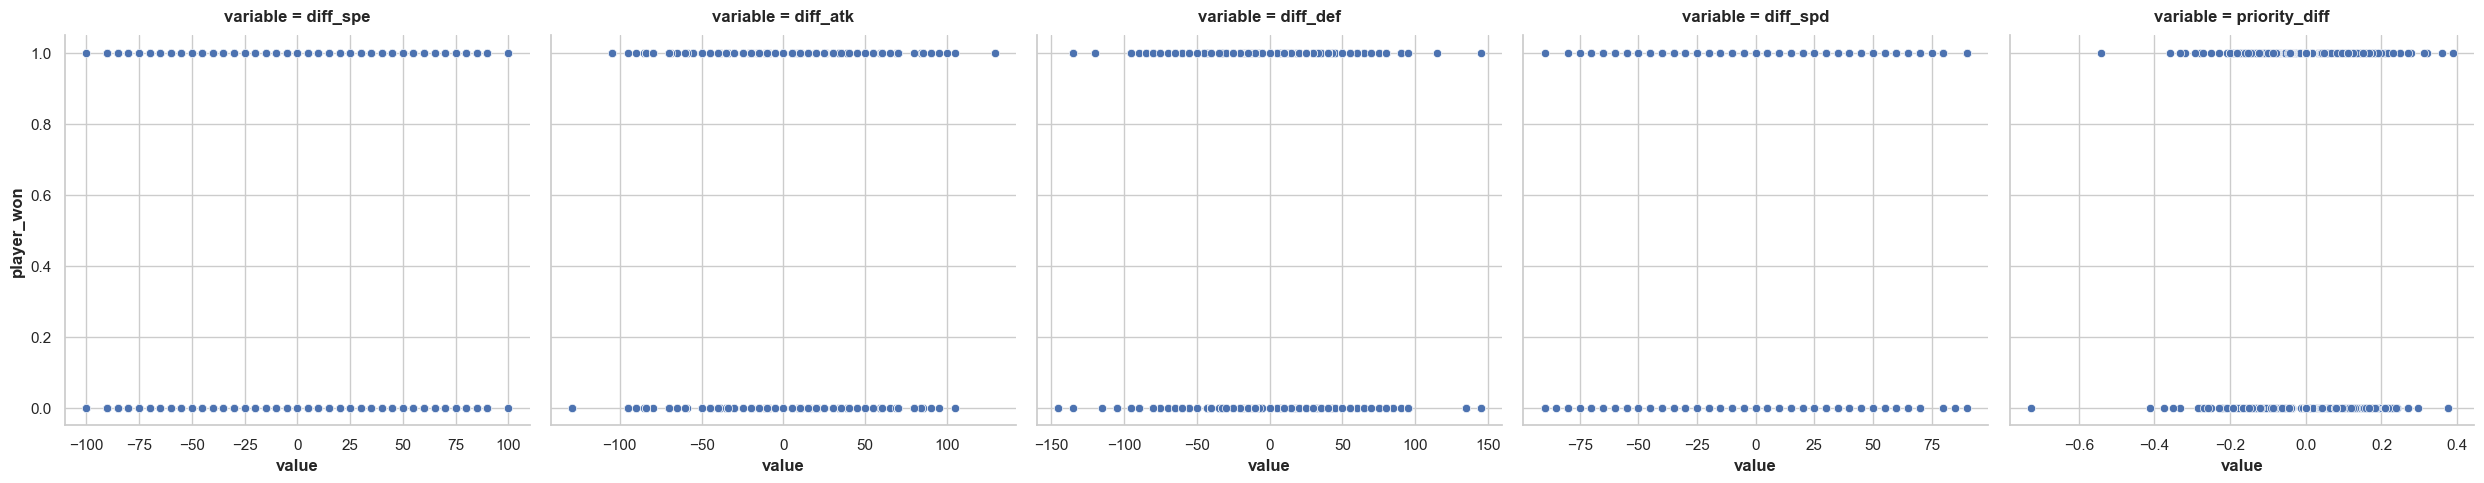

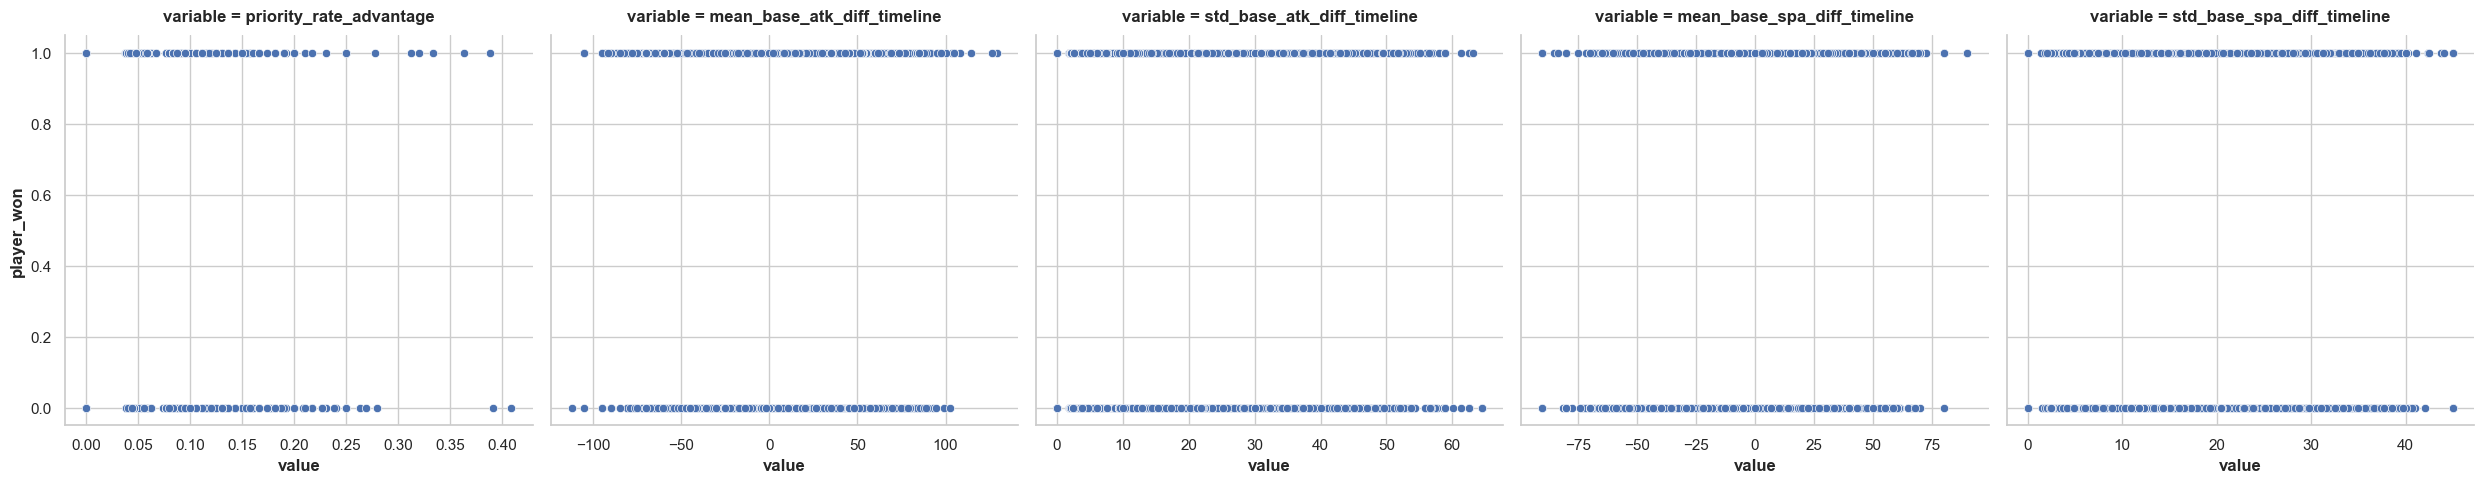

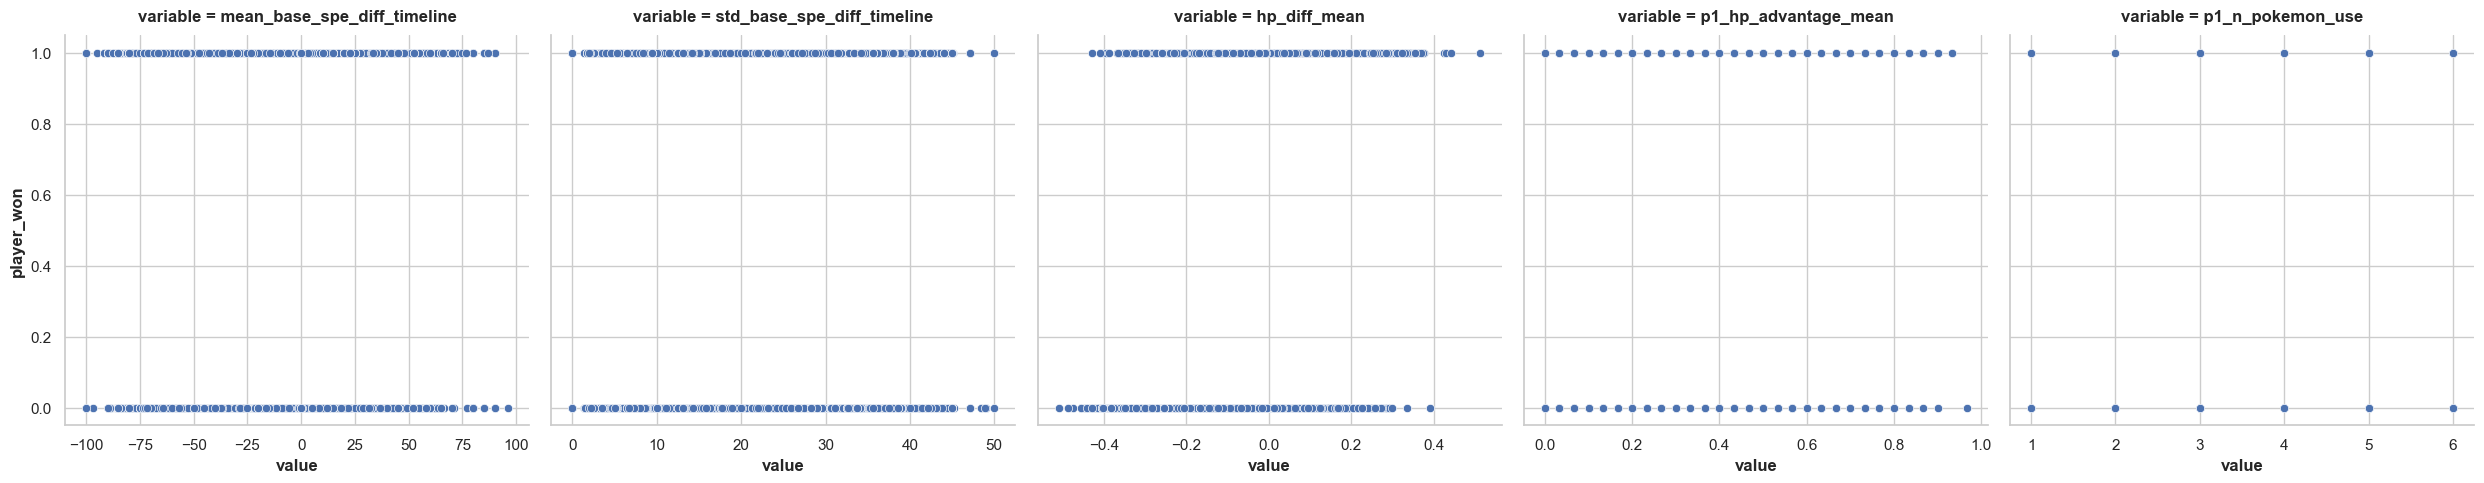

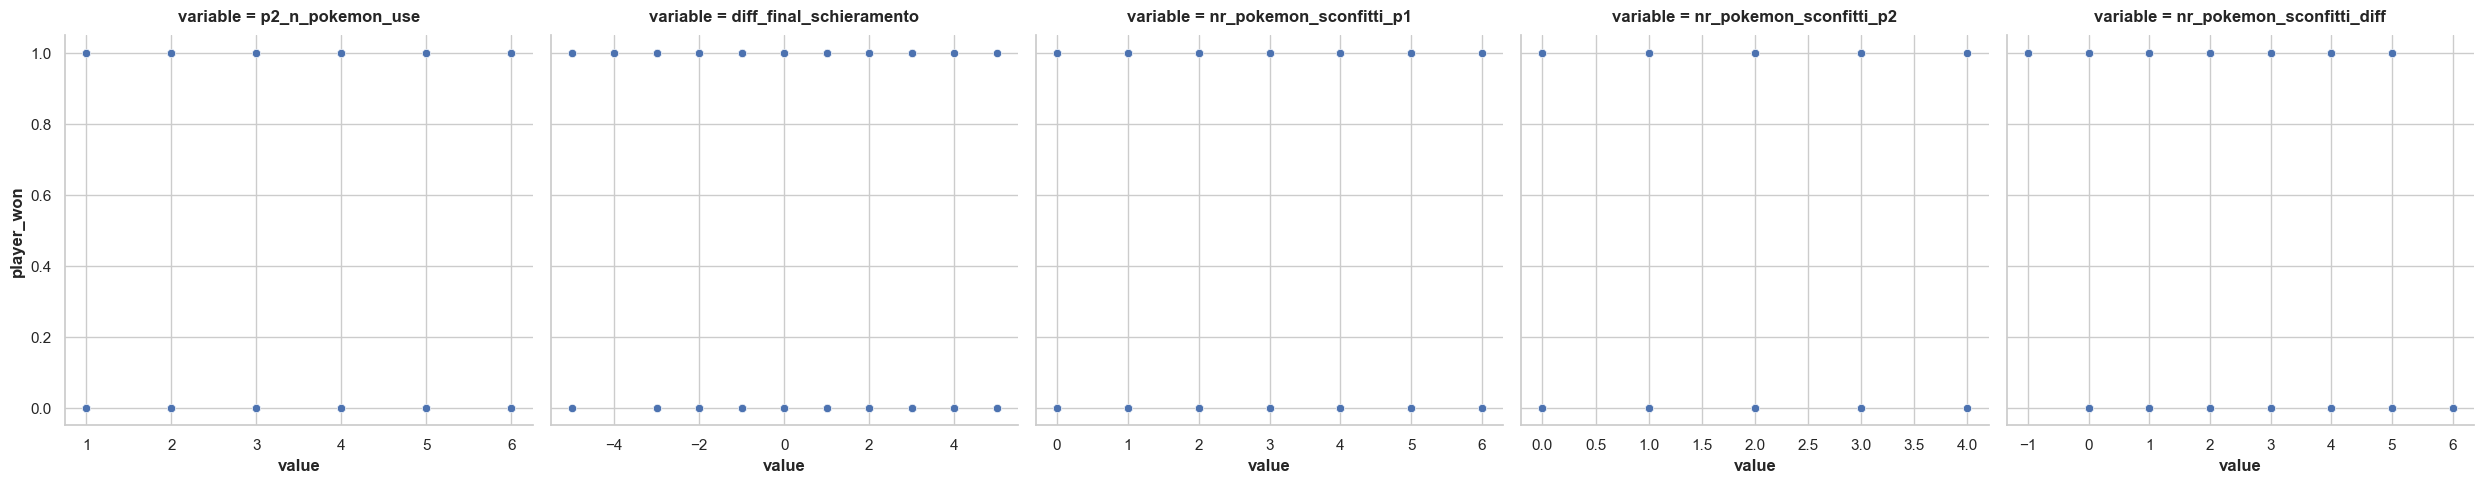

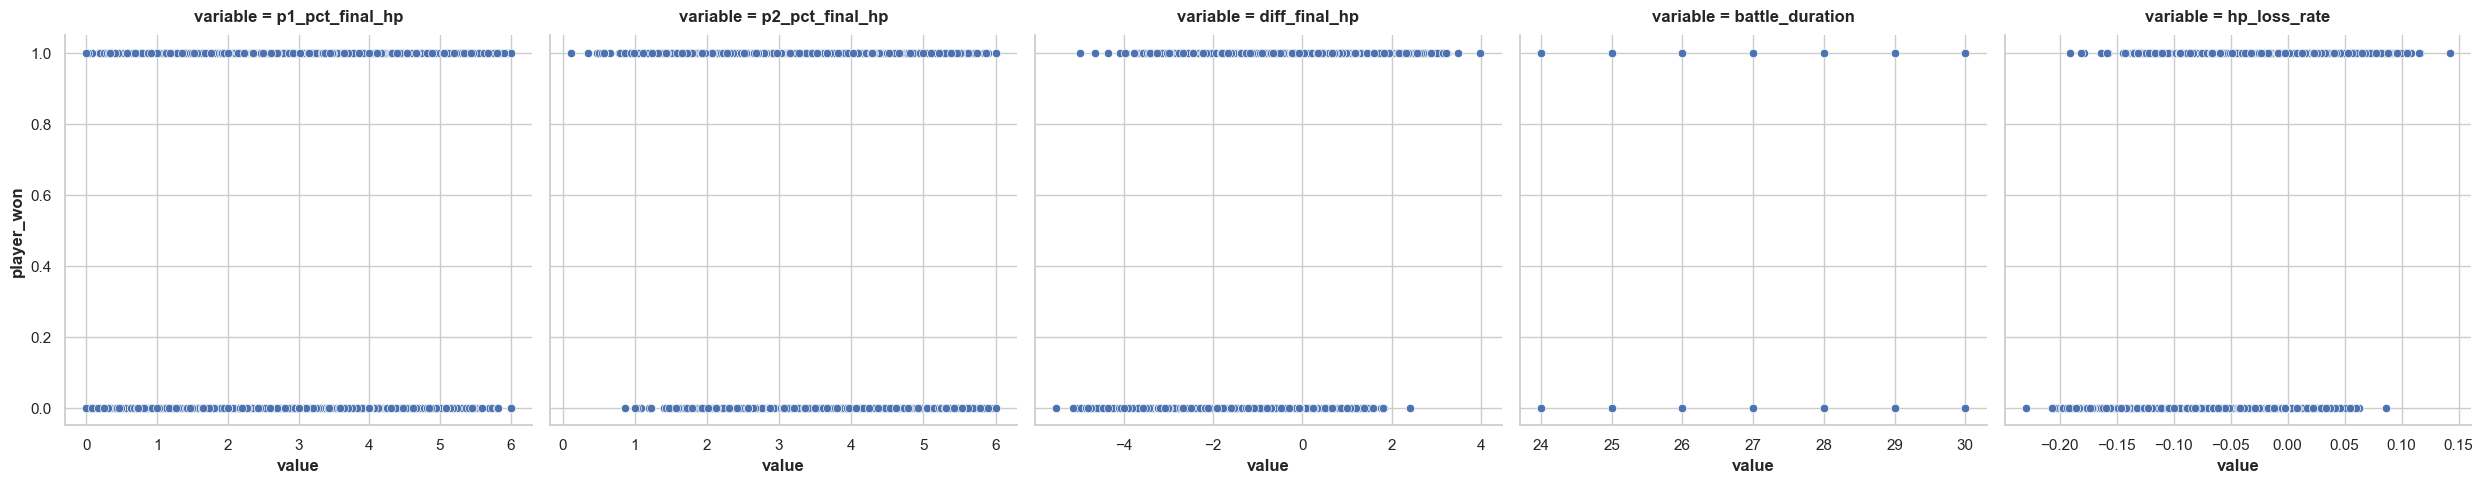

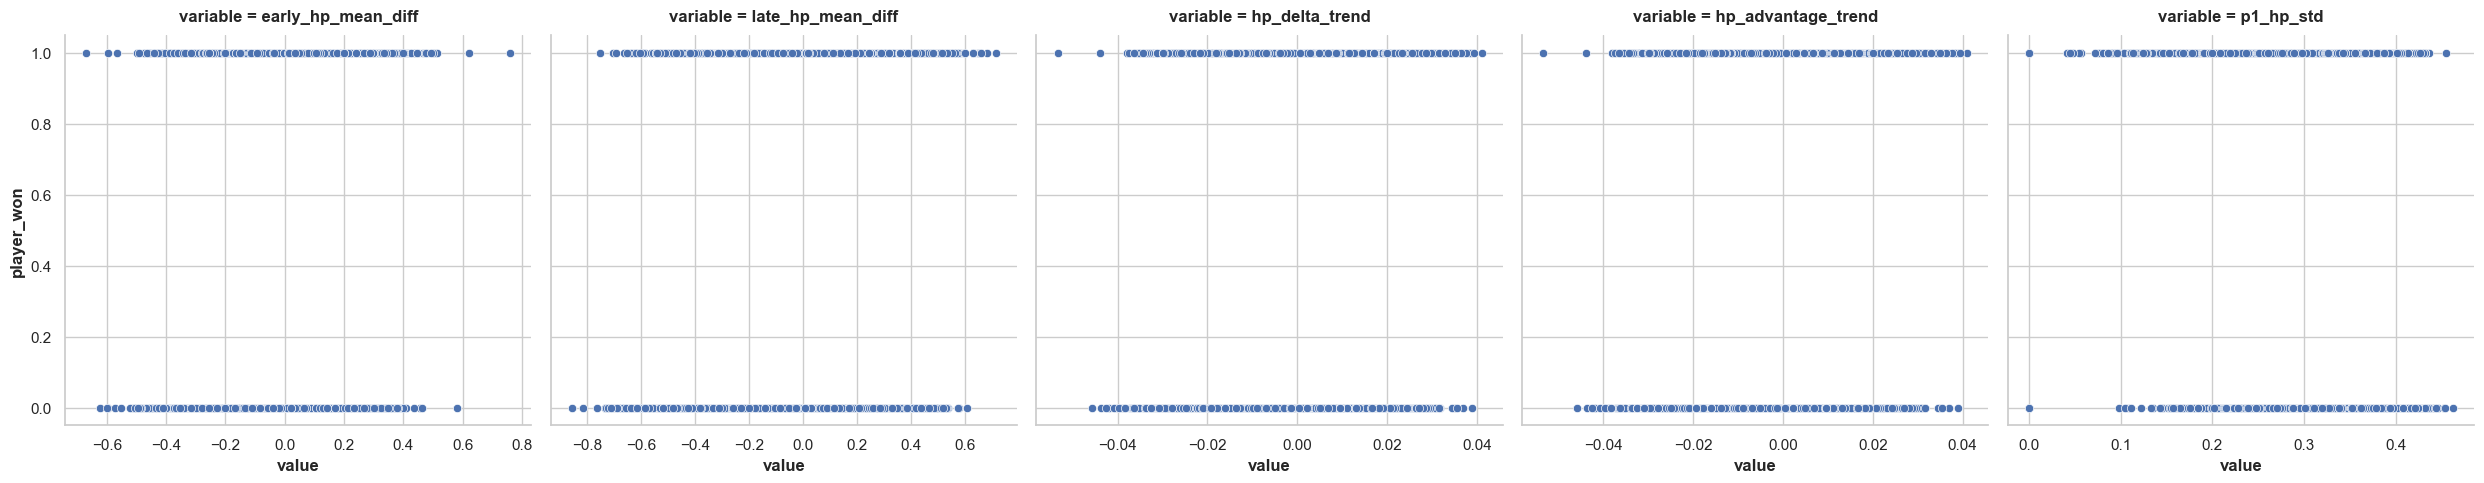

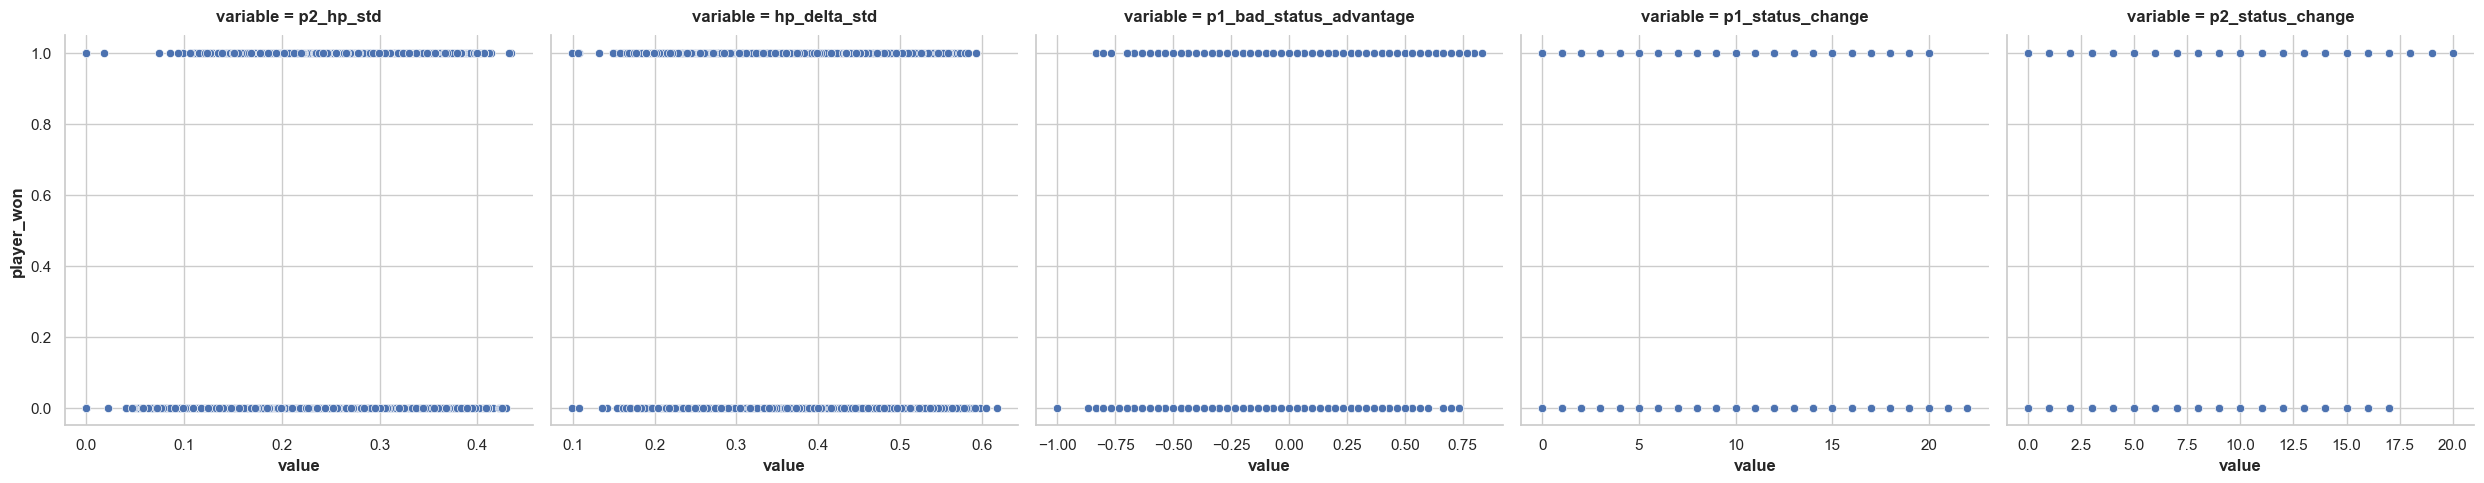

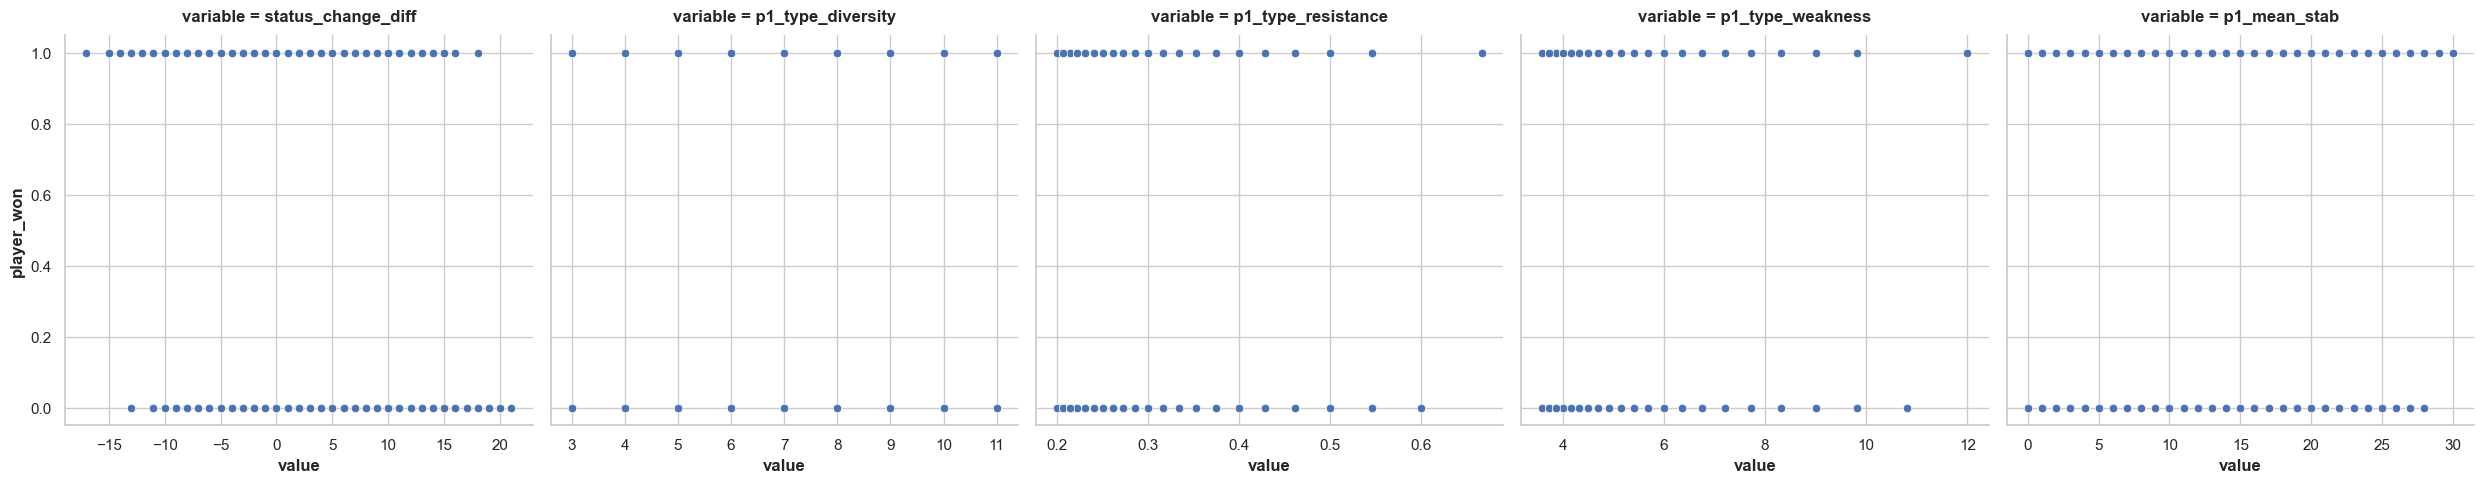

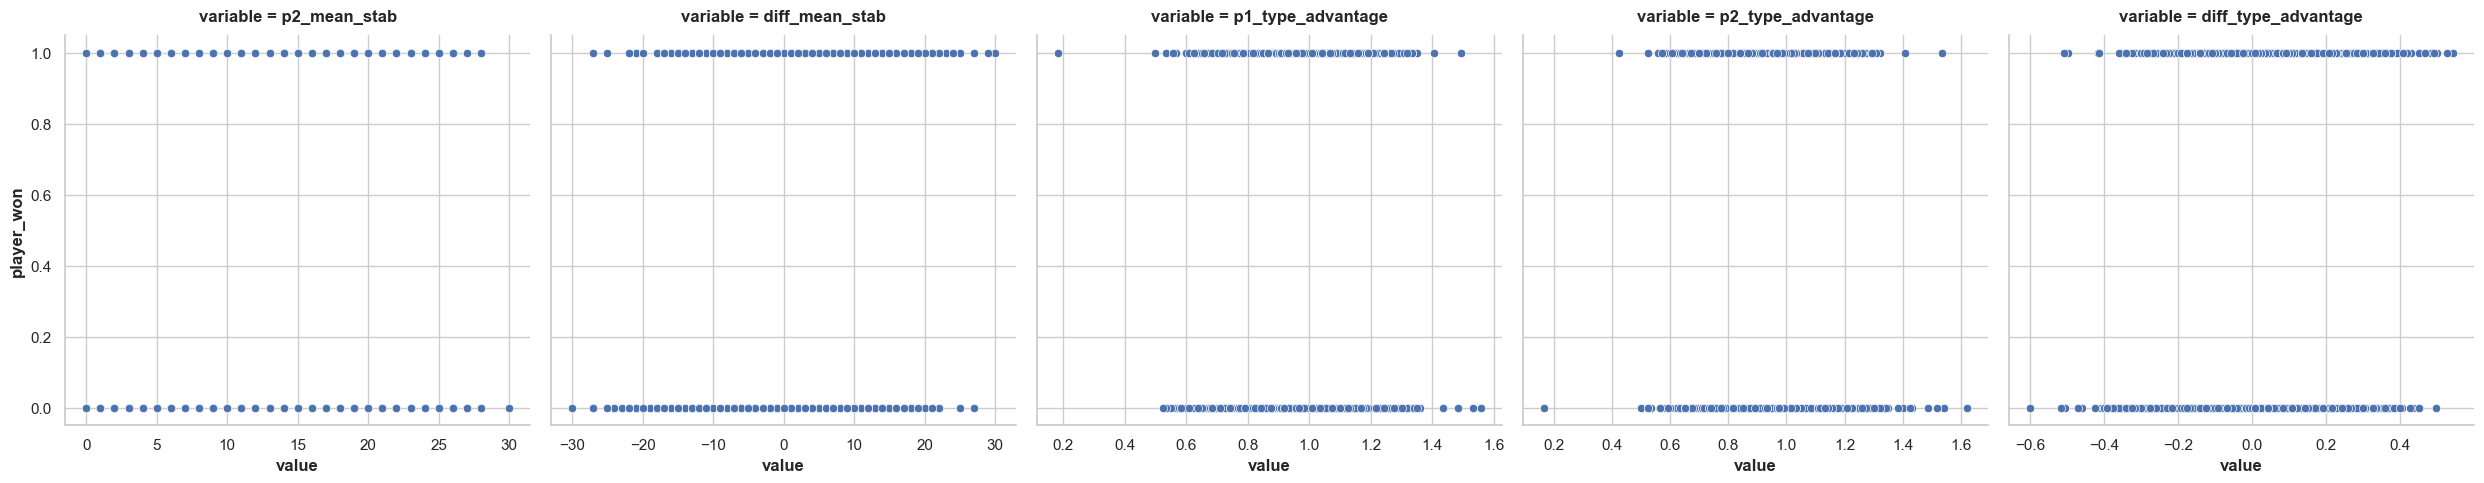

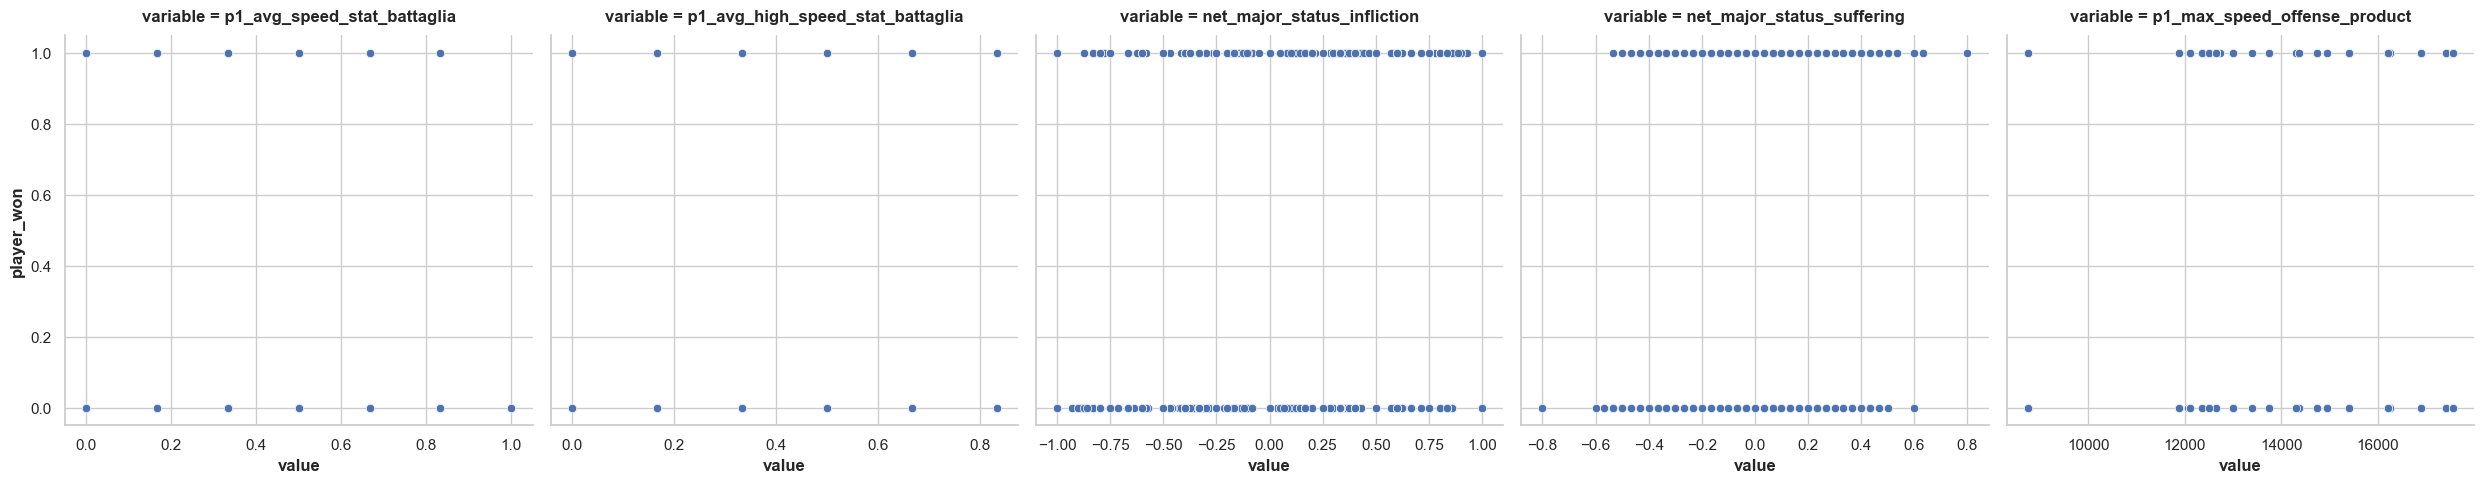

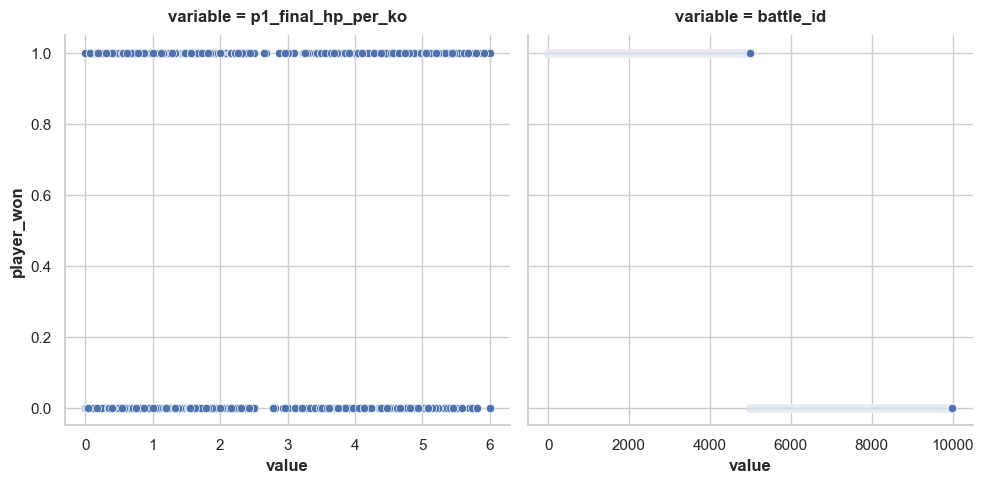

In [23]:
step = 5
for i in range(0,len(df.columns), step):
    features = df.columns[i:i+step]#['battle_duration', 'nr_pokemon_sconfitti_p1','p1_type_advantage']#df.columns[0:5]
    sns.relplot(
        x="value", y="player_won", col="variable", data=df.melt(id_vars="player_won", value_vars=features), facet_kws=dict(sharex=False),
    );

In [24]:
X = df.copy()
#print(X.isna().all())
for col in X.columns:
    if(X[col].isna().sum() > 0):
        print(col,X[col].isna().sum())
    #print(col, X[col].shape, X[col].isna().sum())



In [25]:
X = df.copy()
X.pop('battle_id')
y = X.pop('player_won')
# print(X.shape)
# step = 3
# mi_scores = None
# for i in range(0, len(X.columns), step):
#     X_cols = X.columns[i:i+step]
#     #print(f"Making MI Score for {X_cols}")
#     mi_scores = make_mi_scores(X[X_cols], y)
mi_scores = make_mi_scores(X, y)

mi_scores:  diff_final_hp                       0.275395
hp_loss_rate                        0.264871
status_change_diff                  0.187566
diff_final_schieramento             0.149607
p1_pct_final_hp                     0.141362
                                      ...   
p1_mean_spe                         0.000000
p1_type_advantage                   0.000000
p1_type_resistance                  0.000000
p1_type_diversity                   0.000000
p1_avg_high_speed_stat_battaglia    0.000000
Name: MI Scores, Length: 66, dtype: float64 (66,)

head: diff_final_hp                           0.275395
hp_loss_rate                            0.264871
status_change_diff                      0.187566
diff_final_schieramento                 0.149607
p1_pct_final_hp                         0.141362
p1_status_change                        0.138975
p1_final_hp_per_ko                      0.138710
nr_pokemon_sconfitti_diff               0.134951
nr_pokemon_sconfitti_p1                 0.12

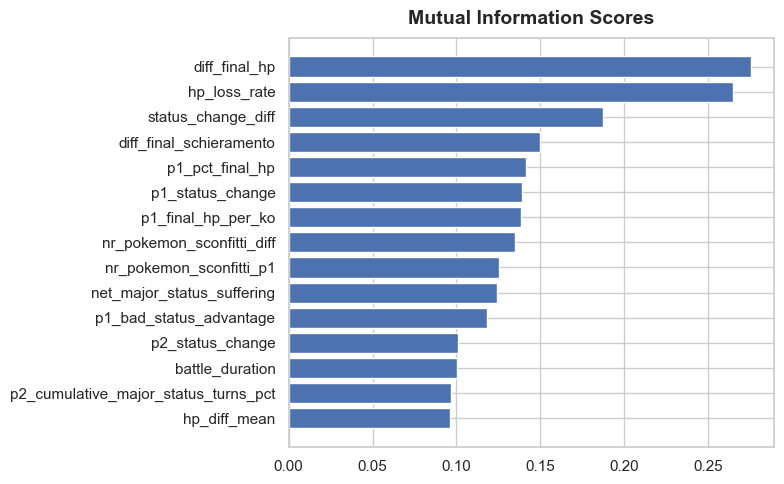

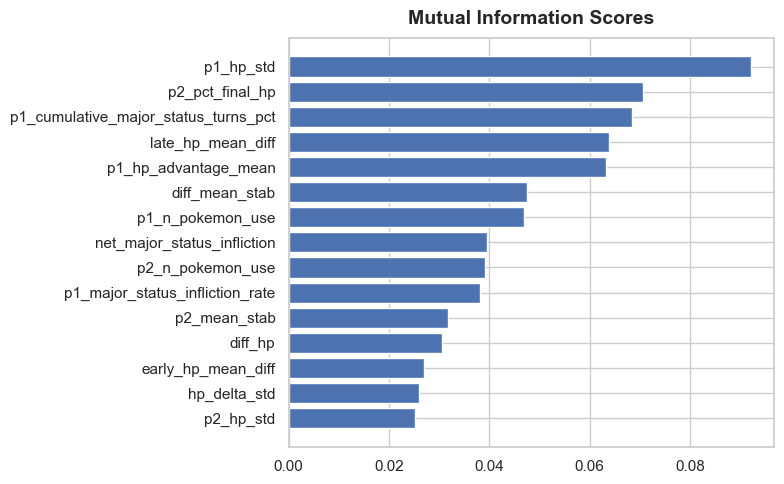

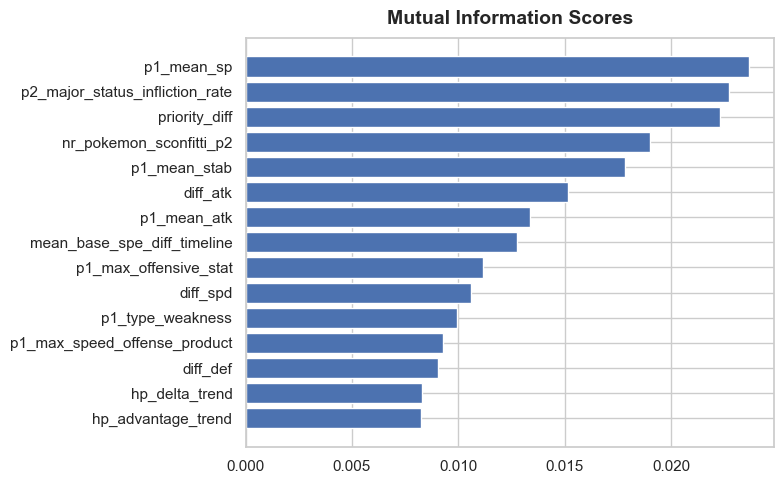

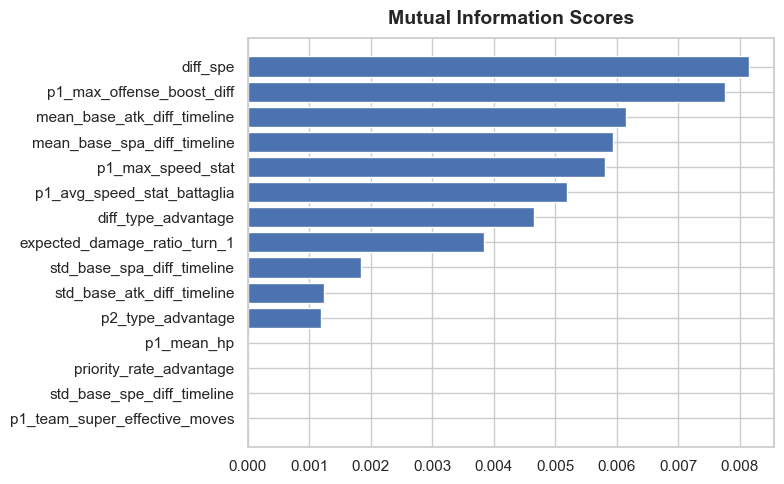

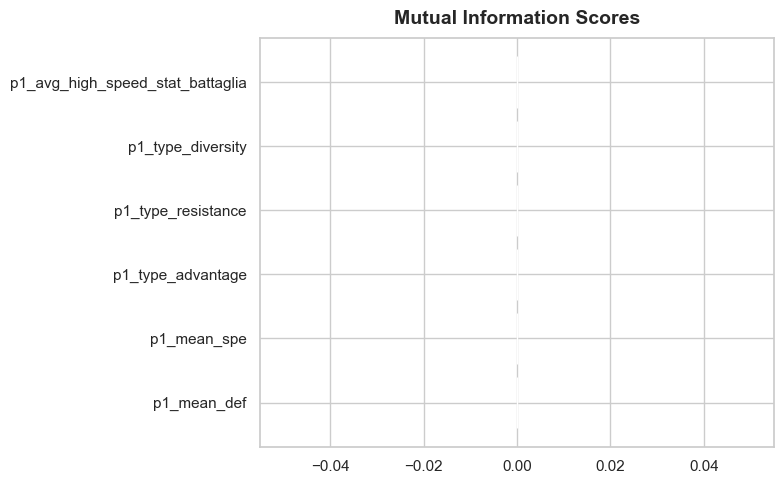

In [26]:
print("mi_scores: ",mi_scores,mi_scores.shape)
print("\nhead:",mi_scores.head(20))
print(mi_scores.tail(20))  # uncomment to see bottom 20


step = 15
for i in range(0,len(mi_scores),step):
    plt.figure(dpi=100, figsize=(8, 5))
    plot_mi_scores(mi_scores[i:i+step])
    #break
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [27]:
import json
import pandas as pd
from tqdm import tqdm  # optional progress bar
import time
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

start = time.time()
import json
import pandas as pd
from tqdm import tqdm
import re
import json
import re
from tqdm import tqdm
import pandas as pd

import json
from collections import Counter

# with open("columns.txt", "r", encoding="utf-8") as f:
#     lines = [line.strip() for line in f if line.strip()]

# dupes = [line for line, count in Counter(lines).items() if count > 1]

# print(f"Found {len(dupes)} duplicate lines:")
# for d in dupes:
#     print(d)
# exit()
# Read only the first line (one JSON object) from the JSONL file
def flatten_dict(d, parent_key="", sep="."):
    """Recursively flatten dicts/lists into a single-level dict."""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            # Flatten short semantic lists like effects or types
            if len(v) > 0 and all(isinstance(x, (str, int, float, bool, type(None))) for x in v):
                for i, val in enumerate(v):
                    items.append((f"{new_key}{sep}{i}", val))
            #skip long or nested lists (like nested dicts)
            else:
                continue
        else:
            items.append((new_key, v))
    return dict(items)


# ---------- 1️⃣ First pass: collect allowed timeline keys ----------
VALID_POKEMON_KEYS = {
    "p1_pokemon_state", "p2_pokemon_state",
    "p1_move_details", "p2_move_details",
}

all_timeline_keys = set()
all_effects = set()  # 👈 collect all unique effects seen in the dataset

with open("input/fds-pokemon-battles-prediction-2025/train.jsonl") as f:
    for line in tqdm(f, desc="Scanning columns"):
        data = json.loads(line.strip())
        if "battle_timeline" not in data:
            continue
        for i, turn in enumerate(data["battle_timeline"], start=1):
            if not isinstance(turn, dict):
                continue
            for key, value in flatten_dict(turn, f"battle_timeline.{i}").items():
                # Skip invalid base-level objects like p1_pokemon_state
                if any(key.endswith(f"{valid}") for valid in VALID_POKEMON_KEYS):
                    continue
                # Collect all effects that appear
                if "effects" in key and isinstance(value, str):
                    all_effects.add(value.strip())
                all_timeline_keys.add(key)

# ---------- 1.5️⃣ Generate per-turn templates ----------
# Normalize keys so turn numbers become a template placeholder
template_keys = {
    re.sub(r"battle_timeline\.\d+\.", "battle_timeline.{turn}.", key)
    for key in all_timeline_keys
}

# ✅ Add all missing effect combinations so each effect exists in every turn
for side in ["p1", "p2"]:
    for eff in all_effects:
        template_keys.add(
            f"battle_timeline.{{turn}}.{side}_pokemon_state.effects.0.{eff}"
        )

# ✅ Ensure *absolute uniqueness* and sorted order
template_keys = sorted(template_keys)
print(f"Collected {len(template_keys)} unique timeline feature templates, including {len(all_effects)} effects.")
# print("Duplicates in template_keys:", len(template_keys) - len(set(template_keys)))
# exit()
# ---------- 2️⃣ Second pass: flatten records ----------
records = []
with open("input/fds-pokemon-battles-prediction-2025/train.jsonl") as f:
    for line in tqdm(f, desc="Flattening"):
        data = json.loads(line.strip())
        flat_record = {}

        # --- Flatten team details ---
        if "p1_team_details" in data and isinstance(data["p1_team_details"], list):
            for i, poke in enumerate(data["p1_team_details"]):
                for key, value in poke.items():
                    if isinstance(value, list):
                        for j, v in enumerate(value):
                            flat_record[f"p1_team_details.{i}.{key}.{j}"] = v
                    else:
                        flat_record[f"p1_team_details.{i}.{key}"] = value

        # --- Flatten p2 lead details ---
        if "p2_lead_details" in data and isinstance(data["p2_lead_details"], dict):
            for key, value in data["p2_lead_details"].items():
                if isinstance(value, list):
                    for j, v in enumerate(value):
                        flat_record[f"p2_lead_details.{key}.{j}"] = v
                else:
                    flat_record[f"p2_lead_details.{key}"] = value

        # --- Flatten timeline turns (1–30) ---
        for turn in range(1, 31):
            if "battle_timeline" in data and len(data["battle_timeline"]) >= turn:
                turn_data = data["battle_timeline"][turn - 1]
                if isinstance(turn_data, dict):
                    for key, value in flatten_dict(turn_data, f"battle_timeline.{turn}").items():
                        if any(valid in key for valid in VALID_POKEMON_KEYS):
                            if any(key.endswith(f"{valid}") for valid in VALID_POKEMON_KEYS):
                                continue
                            flat_record[key] = value
            # Ensure *every* timeline key exists for this turn
            for tmpl in template_keys:
                key = tmpl.format(turn=turn)
                if key not in flat_record:
                    flat_record[key] = None

        # --- Copy top-level keys ---
        for k, v in data.items():
            if k not in ["p1_team_details", "p2_lead_details", "battle_timeline"]:
                flat_record[k] = v
        records.append(flat_record)

# ---------- 3️⃣ Build DataFrame ----------
df = pd.DataFrame(records)
df.columns = [c.replace('.', '_') for c in df.columns]
print(f"✅ Final shape: {df.shape}")




####OLD
bool_cols = df.select_dtypes(include=["bool"]).columns

df[bool_cols] = df[bool_cols].astype(int)

print(f"Converted {len(bool_cols)} boolean columns to integers.")

# df["combined_types"] = df[["p1_team_details_0_types_0", "p1_team_details_0_types_1"]].fillna("notype").agg('-'.join, axis=1)
# df = pd.get_dummies(df, columns=["combined_types"], drop_first=True)
# print(df["combined_types"])
# exit()
unique_types = df.dtypes.unique().tolist()

print("Unique column data types:")
print(unique_types)
type_cols = [col for col in df.columns if "type" in col]
df = pd.get_dummies(df, columns=type_cols, drop_first=True)

#60
cat_cols = [c for c in df.columns if "move_details_category" in c]
df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, drop_first=True)

#status
status_cols = [c for c in df.columns if "state_status" in c]
# print(f"Found {len(status_cols)} state_status columns")
# print(status_cols[:10])  # show a few
# #['nostatus' 'par' 'fnt' 'frz' 'slp' 'tox' 'brn' 'psn']
# for c in status_cols[:5]:  # first few only
#     print(f"{c}: {df[c].unique()}")
# exit()
df = pd.get_dummies(df, columns=status_cols, prefix=status_cols, drop_first=True)

#effect
effects_cols = [c for c in df.columns if "state_effects" in c]
print(f"Found {len(effects_cols)} state_effects columns:")
print(effects_cols[:10])

# unique_effects = set()

# for c in effects_cols:
#     for row in df[c].dropna():
#         if isinstance(row, list):
#             unique_effects.update(row)
#         else:
#             unique_effects.add(row)

# print(f"Found {len(unique_effects)} unique effects:")
# print(sorted(unique_effects))

# exit()


# Identify your state_effects columns
import re
from sklearn.preprocessing import MultiLabelBinarizer

# ✅ only base effect columns (exclude already expanded ones)
effects_cols = [
    c for c in df.columns
    if "state_effects" in c and re.search(r"state_effects_\d+$", c)
]
print(f"Transforming {len(effects_cols)} base state_effects columns...")

mlb = MultiLabelBinarizer()

for c in tqdm(effects_cols, desc="Encoding effects"):
    col_values = df[c]

    # --- Normalize into lists of strings ---
    def normalize_effects(x):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return []
        if isinstance(x, str):
            return [x.strip()]
        if isinstance(x, (list, tuple)):
            out = []
            for el in x:
                if el is None or (isinstance(el, float) and np.isnan(el)):
                    continue
                if isinstance(el, str):
                    out.append(el.strip())
                else:
                    out.append(str(el))
            return out
        return [str(x)]

    col_values = col_values.apply(normalize_effects)

    # --- Skip columns with no effects at all ---
    if sum(len(v) for v in col_values) == 0:
        continue

    # --- ✅ Convert to list-of-lists before fitting ---
    col_list = col_values.tolist()
    mlb.fit(col_list)
    transformed = mlb.transform(col_list)

    # --- Create encoded DataFrame ---
    encoded = pd.DataFrame(
        transformed,
        columns=[f"{c}_{cls}" for cls in mlb.classes_],
        index=df.index
    )

    # --- Merge back ---
    df = pd.concat([df.drop(columns=[c]), encoded], axis=1)


print("✅ All state_effects columns transformed into binary features safely!")
# with open("columns.txt", "w", encoding="utf-8") as f:
#     for col in df.columns:
#         f.write(col + "\n")
# print("finish")
# exit()
#I drop the move names they just add noise
move_name_cols = [c for c in df.columns if "move_details_name" in c]
#print(f"Found {len(move_name_cols)} move_details_name columns")

df = df.drop(columns=move_name_cols)
print(f"Dropped {len(move_name_cols)} move_details_name columns (redundant with move stats).")


#####JOIN


# --- Identify your "team details" columns for player 1
p1_team_cols = [c for c in df.columns if c.startswith("p1_team_details_")]

# --- Extract per-battle Pokémon dictionaries for player 1
def build_pokemon_dict(row, prefix="p1_team_details_"):
    poke_dict = {}
    for i in range(6):  # team slots 0–5
        name_col = f"{prefix}{i}_name"
        if name_col in row and pd.notna(row[name_col]):
            # capture all base_* stats for this slot
            stat_cols = [c for c in df.columns if c.startswith(f"{prefix}{i}_base_")]
            stats = {stat.split("_base_")[-1]: row[stat] for stat in stat_cols}
            poke_dict[row[name_col]] = stats
    return poke_dict


# --- Identify timeline Pokémon name columns
timeline_name_cols = [c for c in df.columns if "pokemon_state_name" in c]

# --- Prepare a dict to collect all new columns (avoid fragmentation)
new_columns = {}

# --- Iterate battles (rows)
for idx, row in df.iterrows():
    # Build Pokémon→stats dictionaries
    p1_map = build_pokemon_dict(row, prefix="p1_team_details_")
    p2_map = build_pokemon_dict(row, prefix="p2_team_details_") if any(
        c.startswith("p2_team_details_") for c in df.columns
    ) else {}

    # Include the P2 lead details if present
    if pd.notna(row.get("p2_lead_details_name")):
        p2_map[row["p2_lead_details_name"]] = {
            k.replace("p2_lead_details_base_", ""): v
            for k, v in row.items()
            if k.startswith("p2_lead_details_base_")
        }

    # For every Pokémon name in the timeline, inject its stats
    for col in timeline_name_cols:
        name = row[col]
        if pd.isna(name):
            continue
        side = "p1" if "_p1_" in col else "p2"
        stat_map = p1_map if side == "p1" else p2_map

        if name in stat_map:
            for stat, value in stat_map[name].items():
                new_col = col.replace("_name", f"_base_{stat}")
                # initialize list if not exists
                if new_col not in new_columns:
                    new_columns[new_col] = [np.nan] * len(df)
                new_columns[new_col][idx] = float(value)

# --- Create one DataFrame with all new stat columns
df_new = pd.DataFrame(new_columns, index=df.index)

# --- Join it once (fast, no fragmentation)
df = pd.concat([df, df_new], axis=1)

# --- Optional: drop original Pokémon name columns (now redundant)
df = df.drop(columns=timeline_name_cols + [c for c in df.columns if c.endswith("_name")])

# --- Optional: defragment memory layout
df = df.copy()

#df = pd.DataFrame(records)

# --- Ensure no duplicate columns remain
df = df.loc[:, ~df.columns.duplicated()].copy()
df.columns = [c.replace('.', '_') for c in df.columns]

print(f"✅ Final shape: {df.shape}")
dupes = df.columns[df.columns.duplicated()]
if len(dupes):
    print("⚠️ Still duplicate columns:", dupes.tolist())
else:
    print("✅ No duplicate columns remain!")

print("✅ Stats injected successfully!")
unique_types = df.dtypes.unique().tolist()

print("Unique column data types:")
print(unique_types)
#####
# Get all boolean columns
# Get all object (dtype 'O') columns
object_cols = df.select_dtypes(include=["object"]).columns.tolist()

print(f"Found {len(object_cols)} object columns:")#381
print(object_cols)

Scanning columns: 10000it [00:53, 185.33it/s]


Collected 47 unique timeline feature templates, including 8 effects.


Flattening: 10000it [01:06, 150.53it/s]


✅ Final shape: (10000, 1482)
Converted 1 boolean columns to integers.
Unique column data types:
[dtype('O'), dtype('int64'), dtype('float64')]
Found 480 state_effects columns:
['battle_timeline_1_p1_pokemon_state_effects_0', 'battle_timeline_1_p2_pokemon_state_effects_0', 'battle_timeline_1_p1_pokemon_state_effects_0_clamp', 'battle_timeline_1_p1_pokemon_state_effects_0_confusion', 'battle_timeline_1_p1_pokemon_state_effects_0_firespin', 'battle_timeline_1_p1_pokemon_state_effects_0_noeffect', 'battle_timeline_1_p1_pokemon_state_effects_0_reflect', 'battle_timeline_1_p1_pokemon_state_effects_0_substitute', 'battle_timeline_1_p1_pokemon_state_effects_0_wrap', 'battle_timeline_1_p2_pokemon_state_effects_0_clamp']
Transforming 60 base state_effects columns...


Encoding effects: 100%|██████████| 60/60 [00:34<00:00,  1.76it/s]


✅ All state_effects columns transformed into binary features safely!
Dropped 60 move_details_name columns (redundant with move stats).
✅ Final shape: (10000, 2829)
✅ No duplicate columns remain!
✅ Stats injected successfully!
Unique column data types:
[dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')]
Found 450 object columns:
['battle_timeline_1_p1_pokemon_state_effects_0_clamp', 'battle_timeline_1_p1_pokemon_state_effects_0_confusion', 'battle_timeline_1_p1_pokemon_state_effects_0_firespin', 'battle_timeline_1_p1_pokemon_state_effects_0_noeffect', 'battle_timeline_1_p1_pokemon_state_effects_0_reflect', 'battle_timeline_1_p1_pokemon_state_effects_0_substitute', 'battle_timeline_1_p1_pokemon_state_effects_0_wrap', 'battle_timeline_1_p2_pokemon_state_effects_0_clamp', 'battle_timeline_1_p2_pokemon_state_effects_0_confusion', 'battle_timeline_1_p2_pokemon_state_effects_0_firespin', 'battle_timeline_1_p2_pokemon_state_effects_0_noeffect', 'battle_timeline_1_p2_pokemon_state_eff

In [28]:
#(10000, 2829)
df = df.drop(columns=object_cols)
df.shape

(10000, 2379)